# 数据连接和清洗 基于xjsh_data

In [38]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [39]:
# 获取指定路径下文件名中包含指定字符串的文件路径
def find_file_with_string(path, string):
    file_list = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if string in file:
                file_list.append(os.path.join(root, file))
    return file_list
# 输入excel文件路径列表，合并excel文件为一个DataFrame
def merge_excel_files(file_list):
    df_list = []
    for file in file_list:
        df = pd.read_excel(file)
        df_list.append(df)
    # 合并所有DataFrame为一个
    merged_df = pd.concat(df_list, ignore_index=True)
    return merged_df

In [40]:
# 分析对象路径
folder_path = r'F:\collection_spb_info\XJSH\ALL_BASE\贵州省'
# 检测信息对象路径
ch_data_path = r'F:\collection_spb_info\XJSH\ALL_JCJG\贵州省'

In [41]:
base_file_list = find_file_with_string(folder_path, 'base_info')
ch_file_list = find_file_with_string(ch_data_path, 'all_info')

In [42]:
ch_df = merge_excel_files(ch_file_list)

In [43]:
base_df = merge_excel_files(base_file_list)

In [44]:
# 点位信息列表
info_list = ['ydbh','dwjd','dwwd','ydlb','yplx','hbgd','xzmc','zldwmc','sfttcpyd','ttcpmc','ttcpydly','tl']
# 理化指标列表
phy_che_list = ['ydbh','yypbh','jcjg','yjz','ph','ylzjhl',
                'qdan','qlin','qjia','qxi',
                'yxlin','sxjia','hxjia','yxliu','yxgui','yxtie','yxmeng','yxtong','yxxing','yxpeng','yxmu','zgong','zshen','zqian','zge','zge2','znie',
                'jxzc11','jxzc12','jxzc13','jxzc14','jxzc1trzd']

In [45]:
# 读取信息
base_df = base_df[info_list]
ch_df = ch_df[phy_che_list]

KeyError: "['yplx'] not in index"

In [35]:
# 连接数据表
df_result_data = pd.merge(base_df,ch_df,on='ydbh',how='left')

In [36]:
df_result_data.shape

(144757, 42)

In [37]:
# 保存路径
save_path = r"F:\collection_spb_info\sp_float_data\GZS\gzs_result_all.xlsx"
# 获取目录，如果没有则创建
if not os.path.exists(os.path.dirname(save_path)):
    os.makedirs(os.path.dirname(save_path))
else:
    print("目录已存在")
df_result_data.to_excel(save_path,index=False)

In [30]:
len(pd.unique(df_result_data['ydbh']))

116830

In [27]:
# 选择yplx为1和2的行，yypbh列中末尾不以11或10结尾的行
df_result_data['yypbh'] = df_result_data['yypbh'].astype('str')
df_result_data = df_result_data[(df_result_data['yplx']==1) | (df_result_data['yplx']==2)]
df_result_data = df_result_data[~df_result_data['yypbh'].str.endswith(('11', '10'))]

In [28]:
len(pd.unique(df_result_data['ydbh']))

116829

In [32]:
# 删除jcjg列中为-1的行
df_result_data['jcjg'] = df_result_data['jcjg'].astype('str')
df_result_data = df_result_data[df_result_data['jcjg']!='-1.0']

In [33]:
len(pd.unique(df_result_data['ydbh']))

116830

In [230]:
# 先找出所有重复的 ydbh
duplicates = df_result_data.duplicated(subset=['ydbh'], keep=False)

# 为重复的行创建一个组索引
df_result_data['group'] = df_result_data[duplicates].groupby('ydbh').ngroup()

# 定义一个函数来处理每个重复组
def process_group(group):
    # 如果组中有 JCJG 为 1 的行
    if (group['jcjg'] == 1).any():
        # 返回 JCJG 为 1 的第一行的索引
        return group[group['jcjg'] == 1].index[0]
    else:
        # 如果没有 JCJG 为 1 的行，返回组中的第一行的索引
        return group.index[0]

# 获取要保留的行的索引
indices_to_keep = df_result_data[duplicates].groupby('group').apply(process_group)

# 创建一个布尔掩码，标记要保留的行
mask = df_result_data.index.isin(indices_to_keep) | ~duplicates

# 使用掩码筛选数据
result = df_result_data[mask].copy()

# 删除临时的 'group' 列
result.drop('group', axis=1, inplace=True)

# 重置索引
result.reset_index(drop=True, inplace=True)

C:\Users\Runker\AppData\Local\Temp\ipykernel_28320\552464043.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  indices_to_keep = df_result_data[duplicates].groupby('group').apply(process_group)


In [231]:
result

,ydbh,ydlb,dwjd,dwwd,ph,ylzjhl,yjz,qdan,qlin,qjia,...,zge,zge2,znie,yypbh,jcjg,jxzc11,jxzc12,jxzc13,jxzc14,jxzc1trzd
0,5204240101000010,0,105.550051,25.768513,6.88,22.1,46.3,2.63,0.76,18.90,...,0.32,64.8,22.7,520424010100001010,nan,NaN,NaN,NaN,NaN,NaN
1,5204240101000029,0,105.643415,25.765663,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,520424010100002910,nan,NaN,NaN,NaN,NaN,NaN
2,5204240101000031,0,105.714547,25.758127,7.93,34.3,41.5,2.71,1.03,15.30,...,0.84,81.6,42.6,520424010100003110,nan,3.0,36.4,35.7,18.3,黏壤土
3,5204240101000052,0,105.720743,25.790565,7.88,26.3,32.2,2.26,0.88,10.50,...,0.87,115,65.6,520424010100005210,nan,NaN,NaN,NaN,NaN,NaN
4,5204240101000056,0,105.501694,25.960559,4.83,23.6,37.7,2.22,1.43,23.00,...,0.31,125,76.3,520424010100005610,nan,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
954,5204240404000824,0,105.714679,25.867510,6.98,40.1,55.6,2.59,1.26,4.30,...,/,/,/,520424040400082410,nan,/,/,/,/,/
955,5204240404000852,0,105.461477,25.807122,8.07,29.1,33.0,1.76,0.36,3.99,...,/,/,/,520424040400085210,nan,/,/,/,/,/
956,5204240404000893,0,105.544106,26.004347,4.92,20.2,62.8,3.53,1.49,12.90,...,0.56,201,105,520424040400089310,nan,4.6,4.6,24.6,57.7,黏土
957,5204240404000908,0,105.417045,25.917704,7.26,47.8,60.9,3.70,0.65,39.40,...,/,/,/,520424040400090810,nan,/,/,/,/,/


In [232]:
len(pd.unique(result['ydbh']))

959

In [233]:
# 替换指定列中的非数值型值为0.0001
flot_value_list = ['yjz','ph','ylzjhl','qdan','qlin','qjia','qxi','yxlin','sxjia','hxjia','yxliu','yxgui','yxtie','yxmeng','yxtong','yxxing',
                   'yxpeng','yxmu','zgong','zshen','zqian','zge','zge2','znie','jxzc11','jxzc12','jxzc13','jxzc14','jxzc1trzd']
for one_col in phy_che_list[:-1]:
    result[one_col] = pd.to_numeric(result[one_col], errors='coerce').fillna(0.0001)

In [234]:
result

,ydbh,ydlb,dwjd,dwwd,ph,ylzjhl,yjz,qdan,qlin,qjia,...,zge,zge2,znie,yypbh,jcjg,jxzc11,jxzc12,jxzc13,jxzc14,jxzc1trzd
0,5204240101000010,0,105.550051,25.768513,6.8800,22.1000,46.3000,2.6300,0.7600,18.9000,...,0.3200,64.8000,22.7000,520424010100001010,0.0001,0.0001,0.0001,0.0001,0.0001,NaN
1,5204240101000029,0,105.643415,25.765663,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,...,0.0001,0.0001,0.0001,520424010100002910,0.0001,0.0001,0.0001,0.0001,0.0001,NaN
2,5204240101000031,0,105.714547,25.758127,7.9300,34.3000,41.5000,2.7100,1.0300,15.3000,...,0.8400,81.6000,42.6000,520424010100003110,0.0001,3.0000,36.4000,35.7000,18.3000,黏壤土
3,5204240101000052,0,105.720743,25.790565,7.8800,26.3000,32.2000,2.2600,0.8800,10.5000,...,0.8700,115.0000,65.6000,520424010100005210,0.0001,0.0001,0.0001,0.0001,0.0001,NaN
4,5204240101000056,0,105.501694,25.960559,4.8300,23.6000,37.7000,2.2200,1.4300,23.0000,...,0.3100,125.0000,76.3000,520424010100005610,0.0001,0.0001,0.0001,0.0001,0.0001,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
954,5204240404000824,0,105.714679,25.867510,6.9800,40.1000,55.6000,2.5900,1.2600,4.3000,...,0.0001,0.0001,0.0001,520424040400082410,0.0001,0.0001,0.0001,0.0001,0.0001,/
955,5204240404000852,0,105.461477,25.807122,8.0700,29.1000,33.0000,1.7600,0.3600,3.9900,...,0.0001,0.0001,0.0001,520424040400085210,0.0001,0.0001,0.0001,0.0001,0.0001,/
956,5204240404000893,0,105.544106,26.004347,4.9200,20.2000,62.8000,3.5300,1.4900,12.9000,...,0.5600,201.0000,105.0000,520424040400089310,0.0001,4.6000,4.6000,24.6000,57.7000,黏土
957,5204240404000908,0,105.417045,25.917704,7.2600,47.8000,60.9000,3.7000,0.6500,39.4000,...,0.0001,0.0001,0.0001,520424040400090810,0.0001,0.0001,0.0001,0.0001,0.0001,/


In [235]:
result.drop('jcjg',axis=1,inplace=True)

In [236]:
# 保存数据
result['ydbh'] = result['ydbh'].astype('str')
result['yypbh'] = result['yypbh'].astype('str')
# 保存路径
save_path = r"F:\collection_spb_info\sp_float_data\GL\gl_result.xlsx"
# 获取目录，如果没有则创建
if not os.path.exists(os.path.dirname(save_path)):
    os.makedirs(os.path.dirname(save_path))
else:
    print("目录已存在")
result.to_excel(save_path,index=False)


目录已存在


# 查看数据

In [237]:
result.columns

Index(['ydbh', 'ydlb', 'dwjd', 'dwwd', 'ph', 'ylzjhl', 'yjz', 'qdan', 'qlin',
       'qjia', 'qxi', 'yxlin', 'sxjia', 'hxjia', 'yxliu', 'yxgui', 'yxtie',
       'yxmeng', 'yxtong', 'yxxing', 'yxpeng', 'yxmu', 'zgong', 'zshen',
       'zqian', 'zge', 'zge2', 'znie', 'yypbh', 'jxzc11', 'jxzc12', 'jxzc13',
       'jxzc14', 'jxzc1trzd'],
      dtype='object')

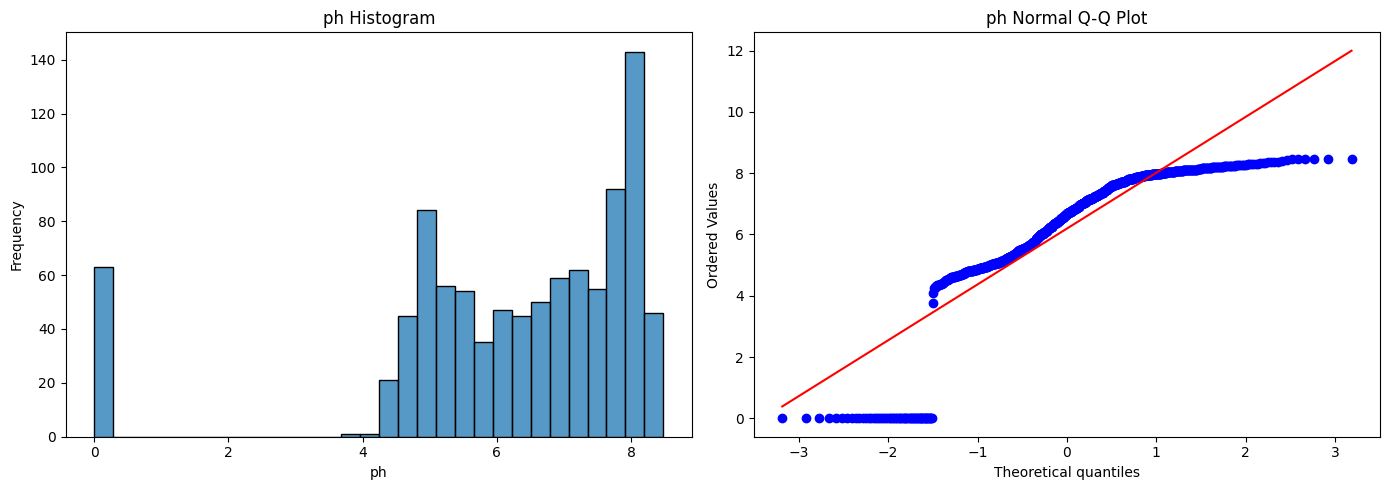

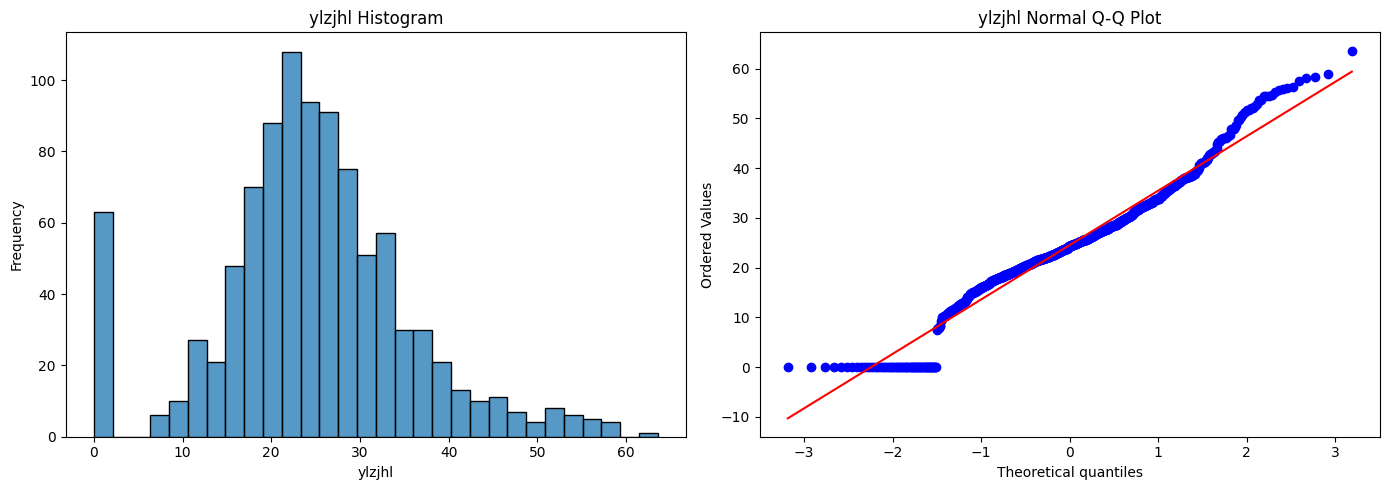

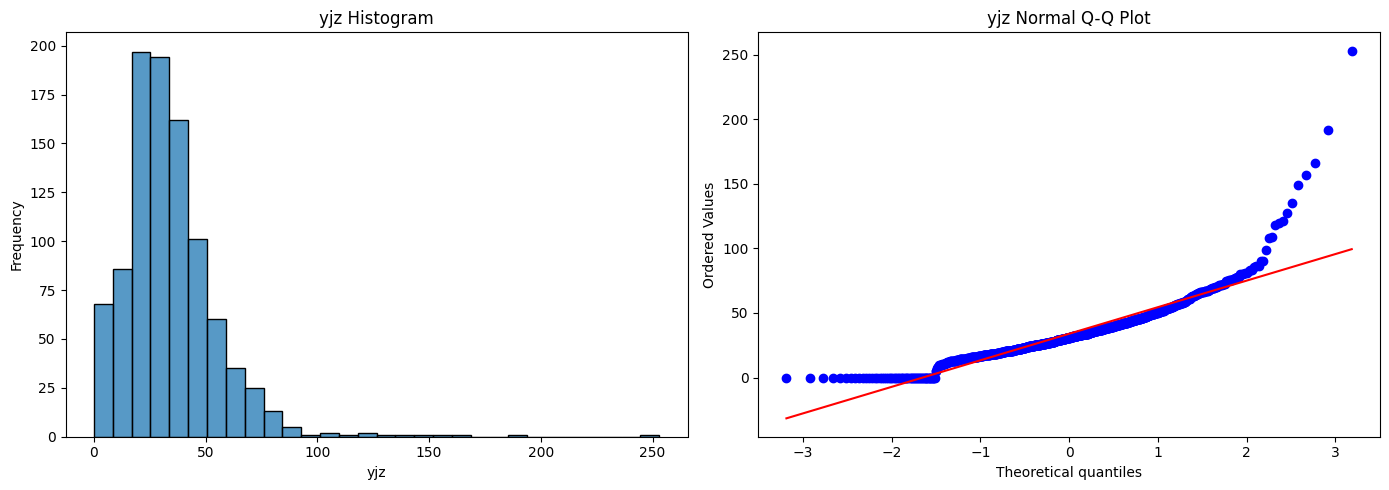

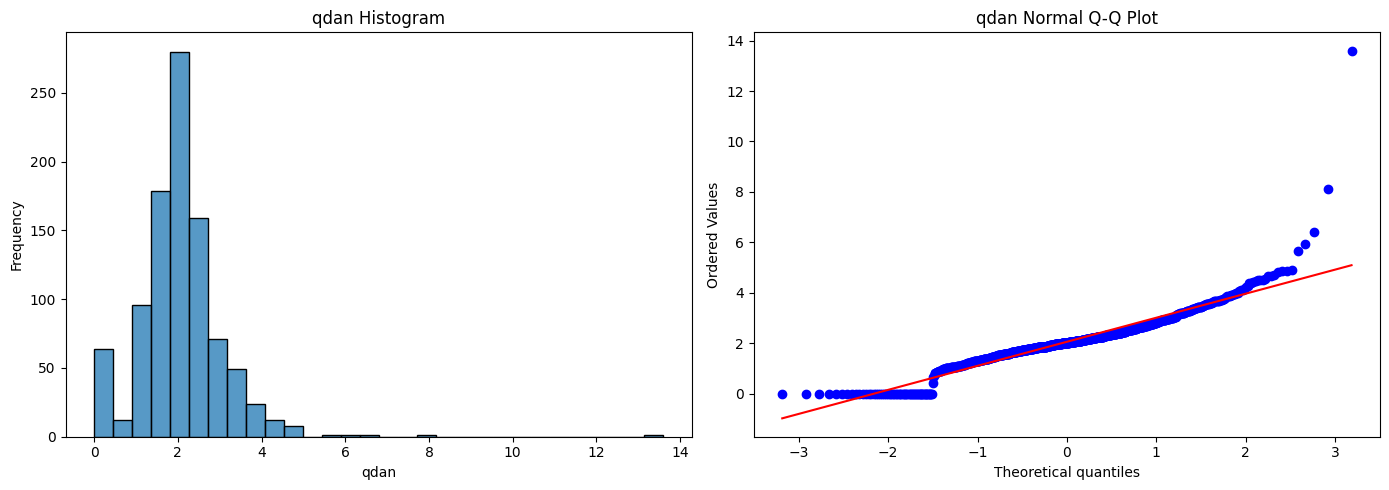

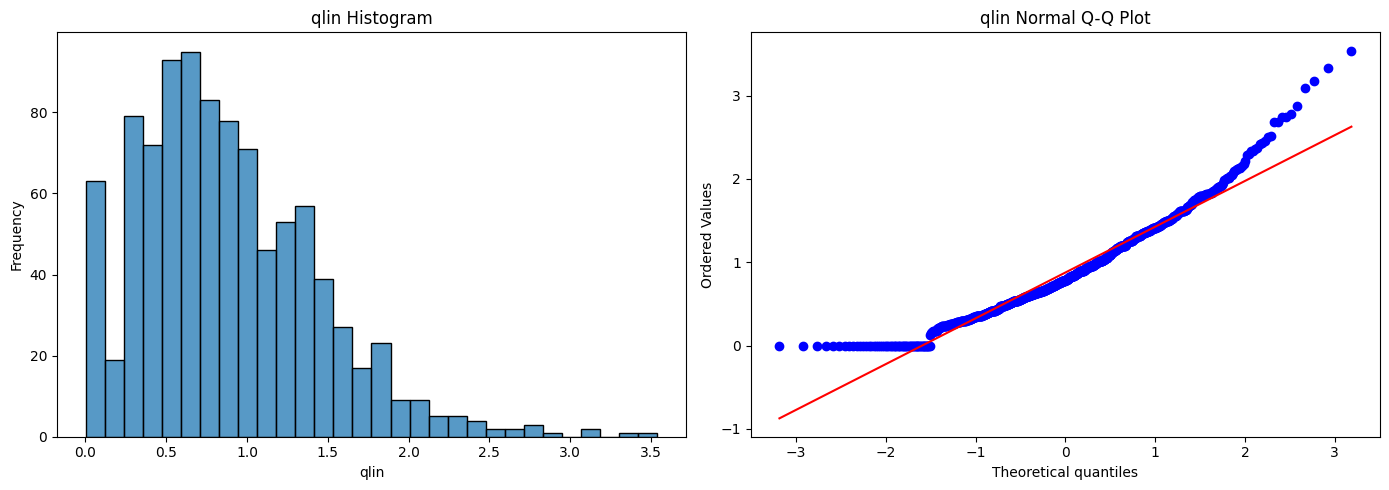

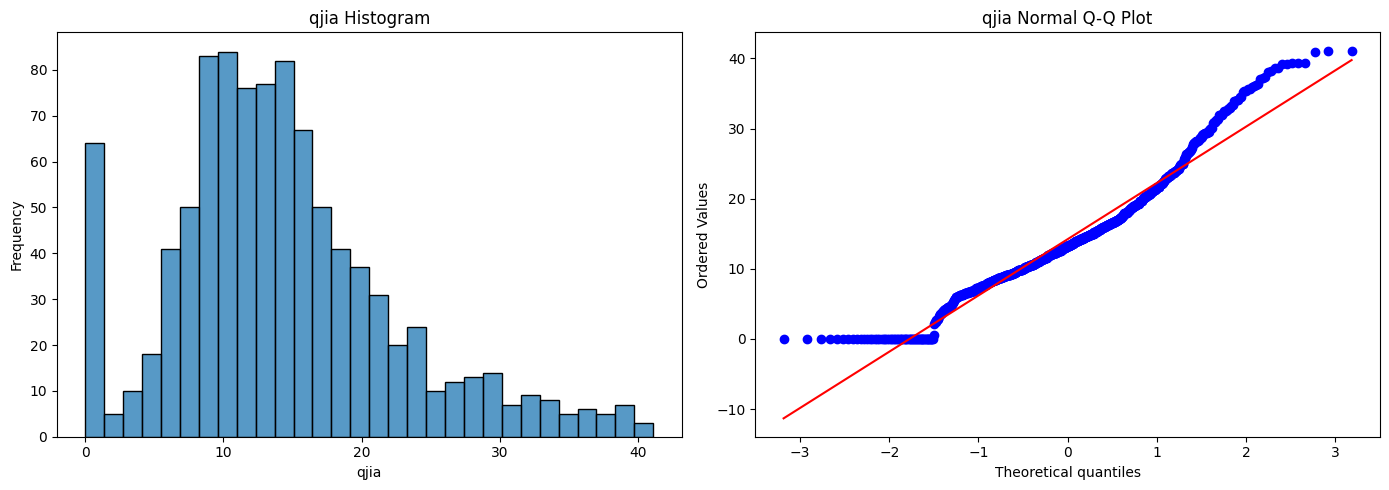

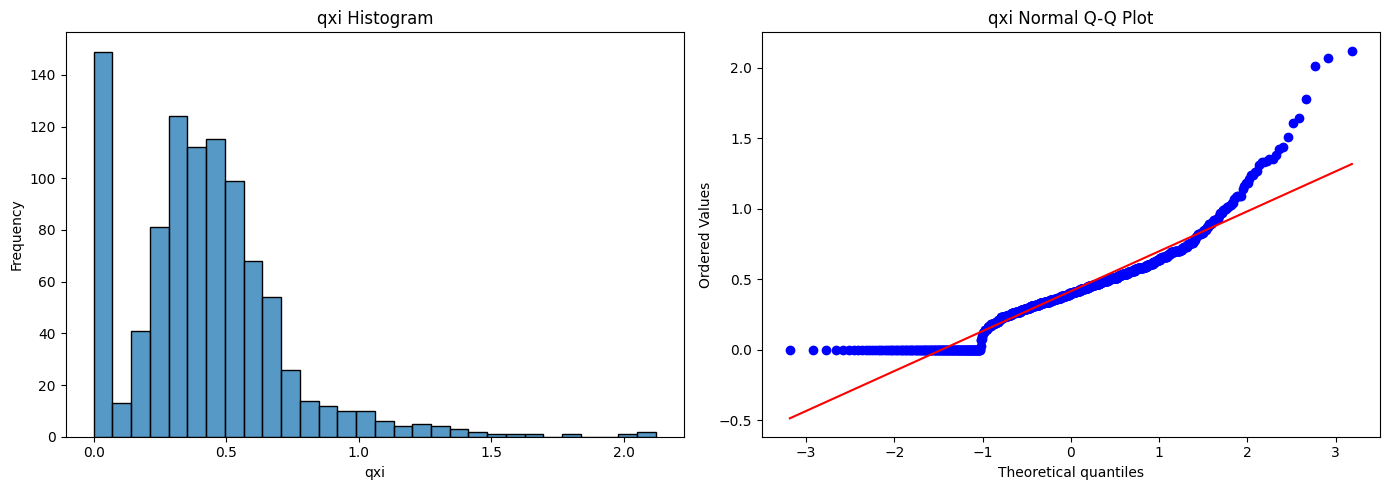

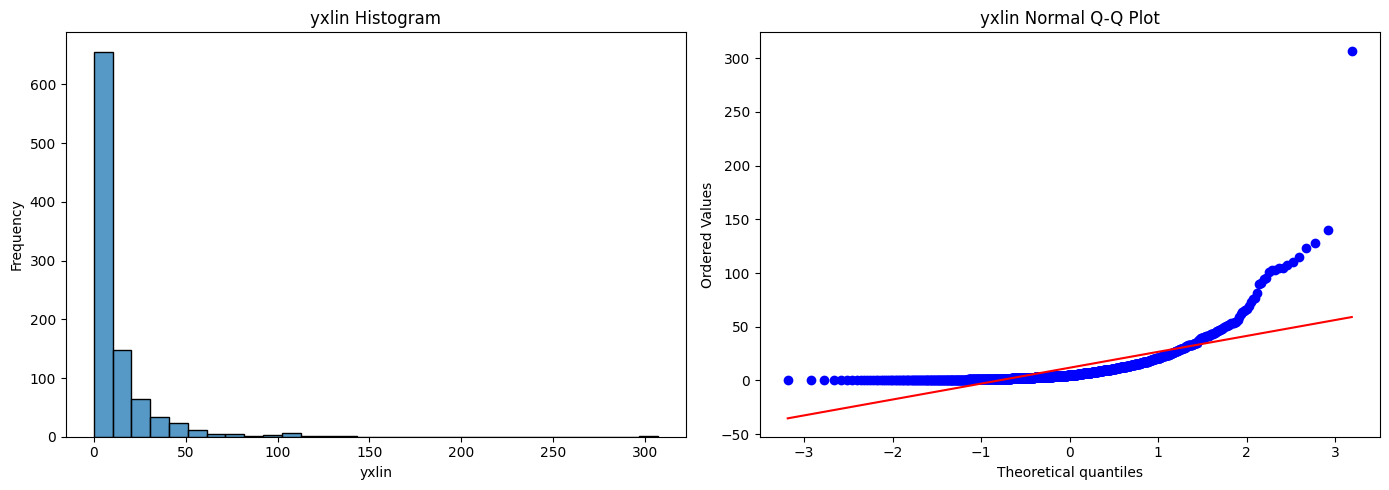

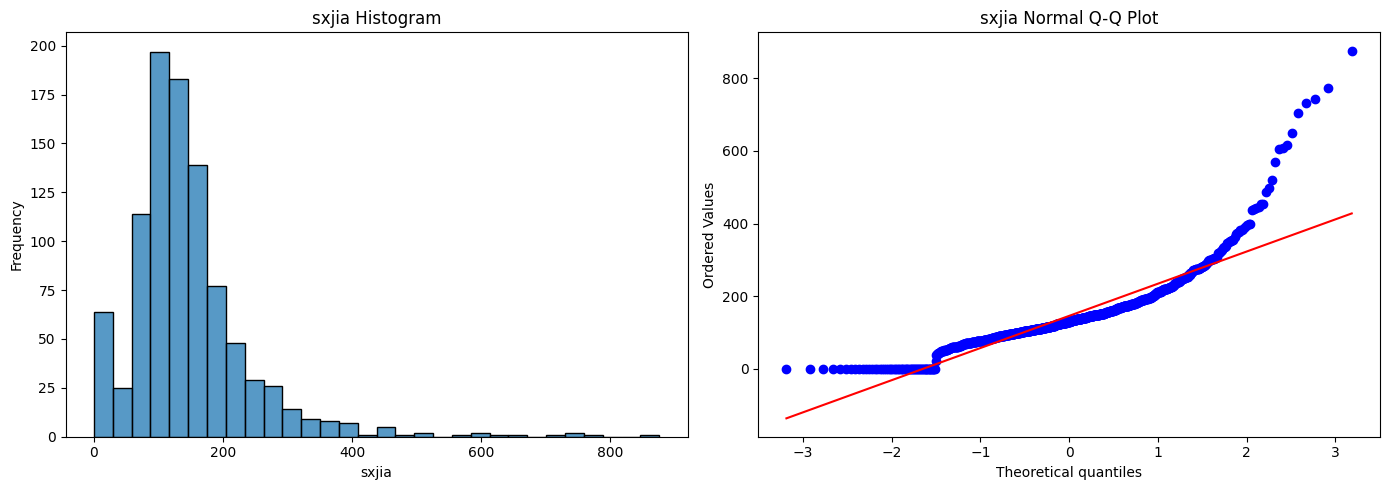

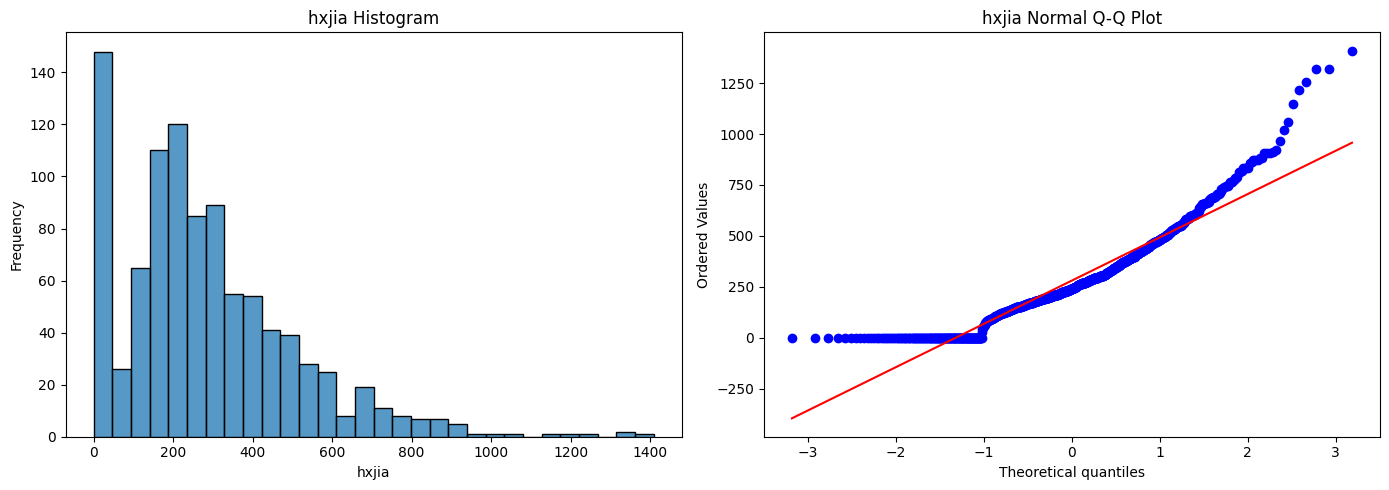

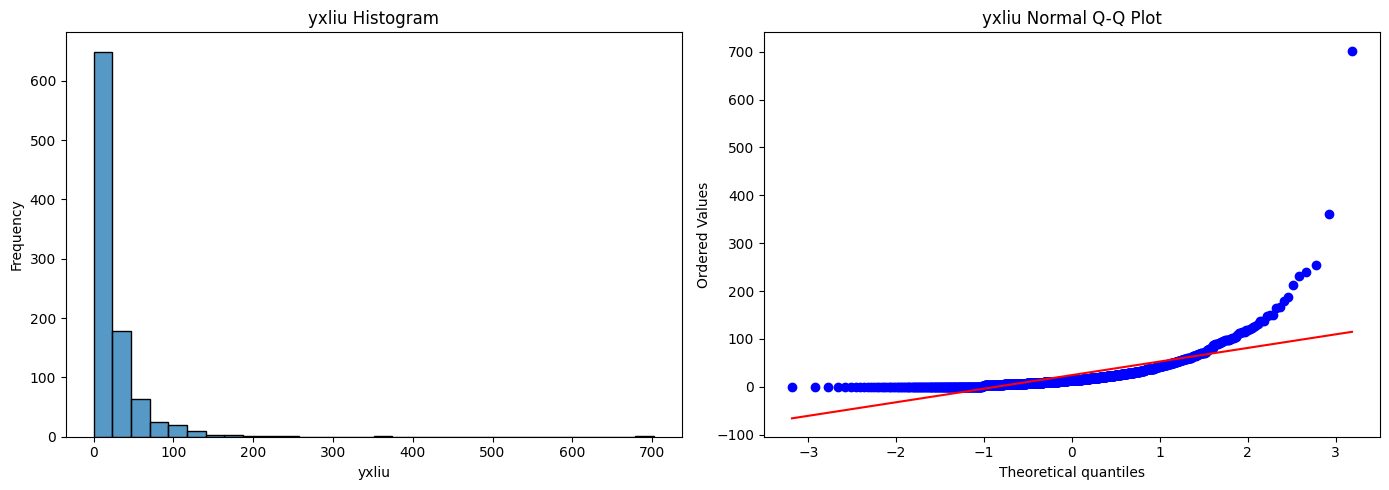

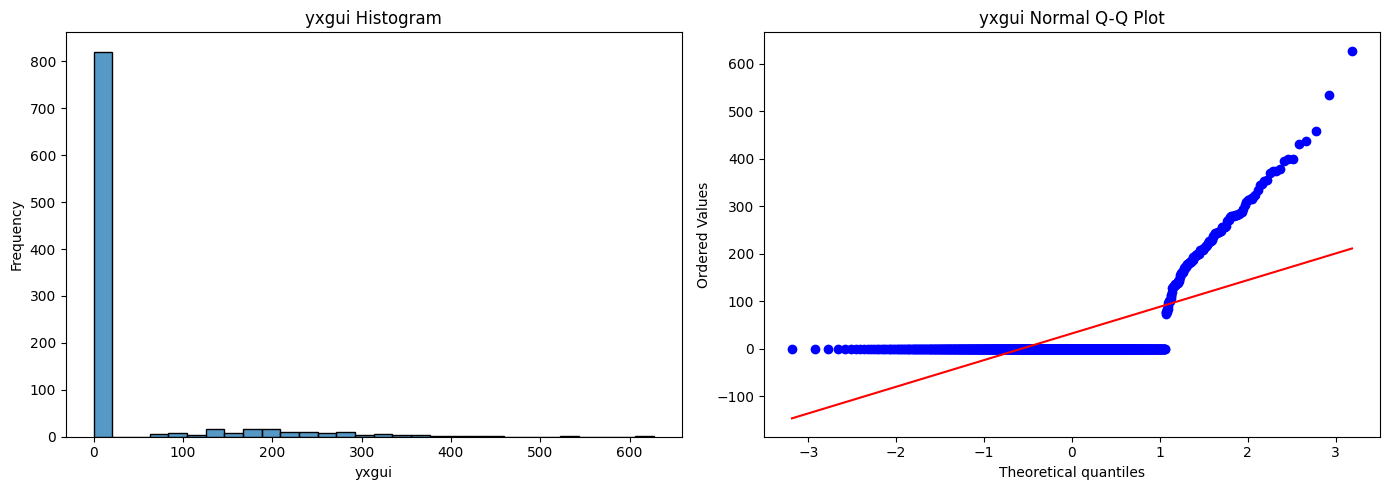

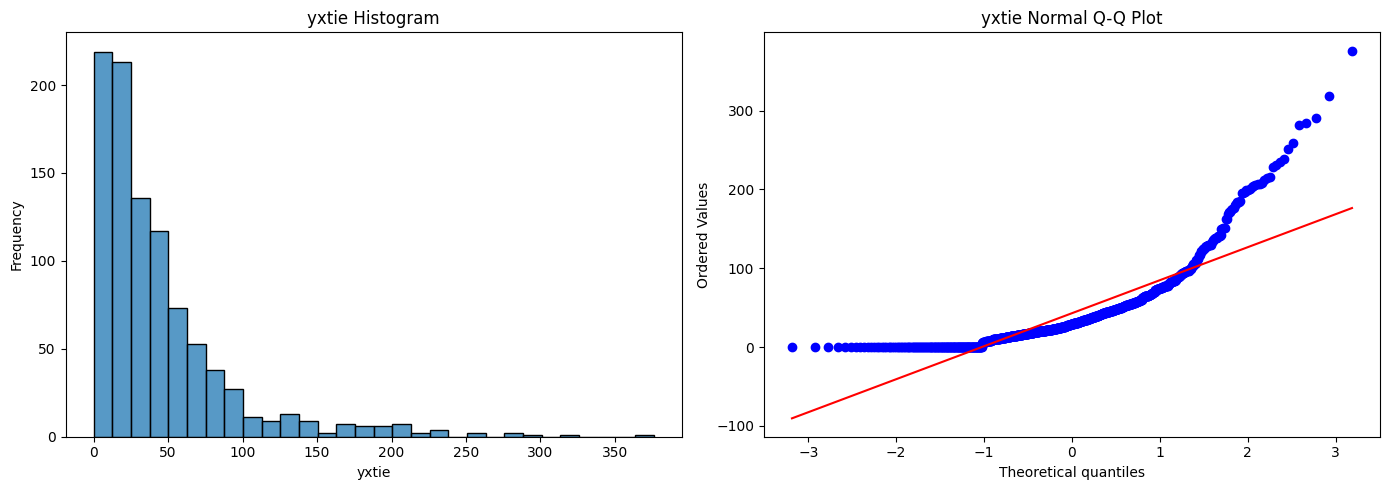

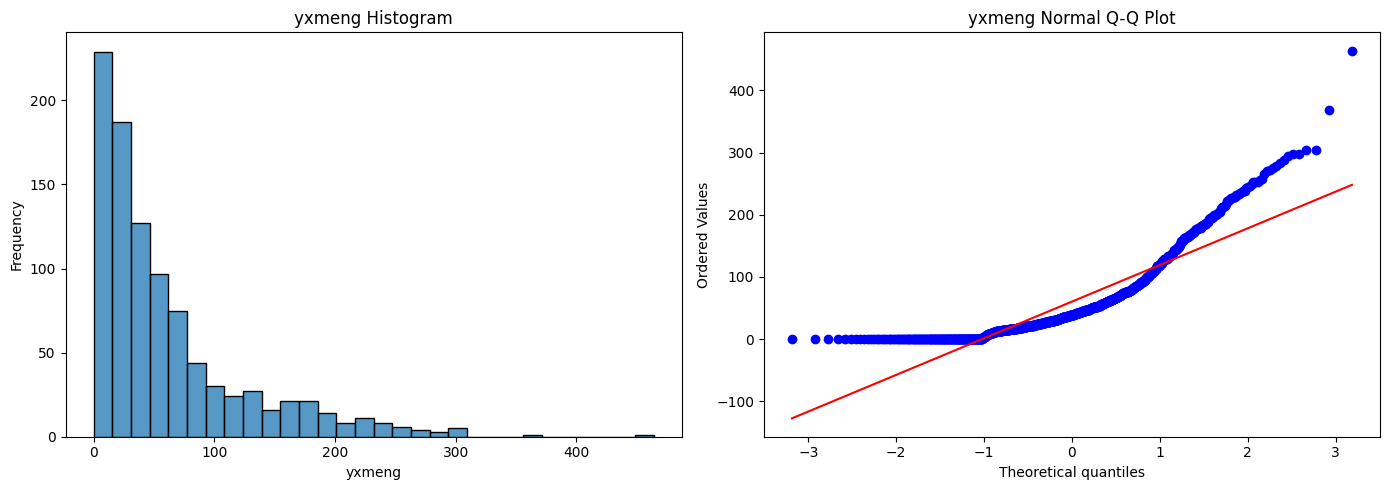

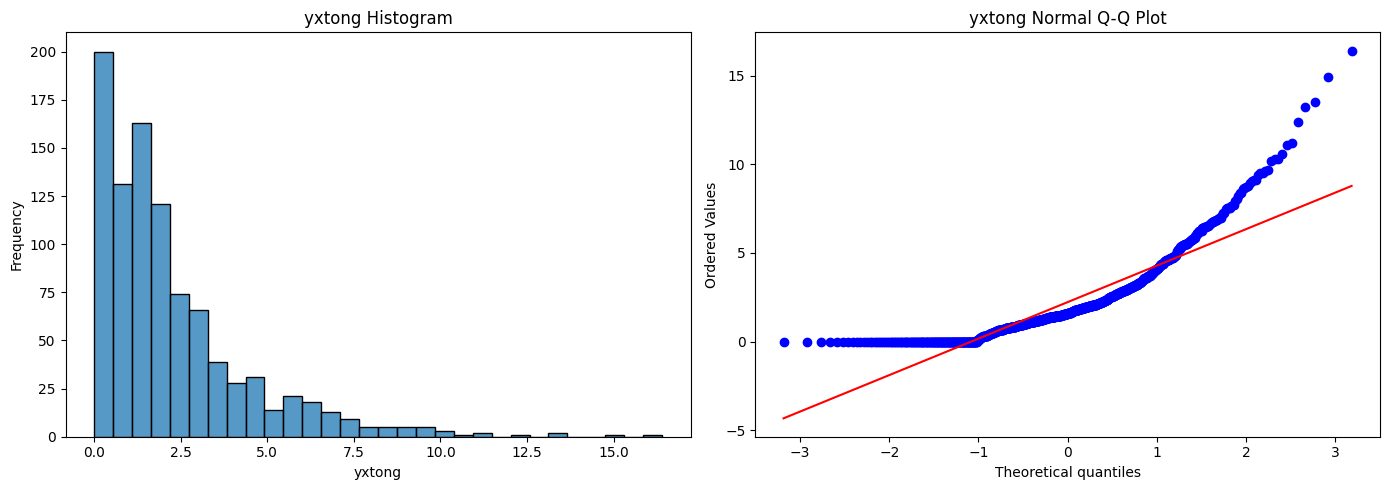

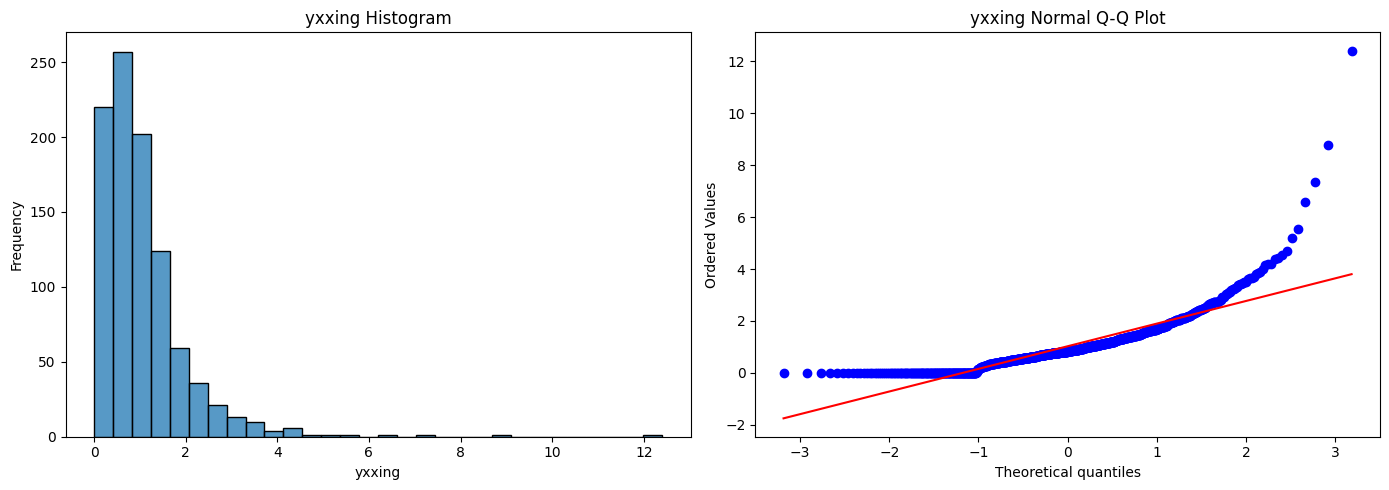

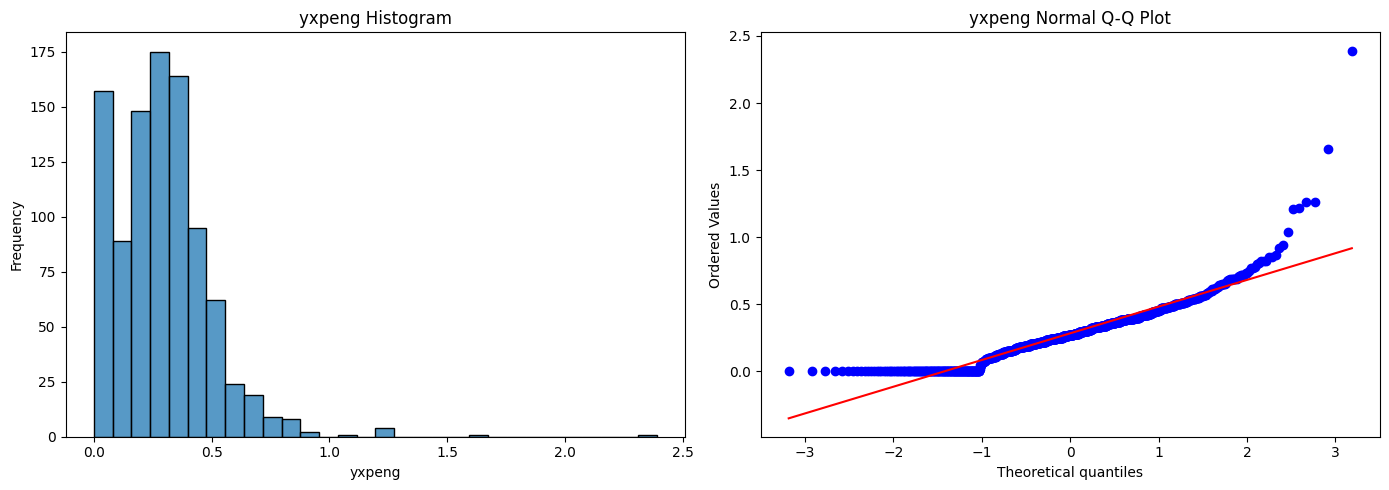

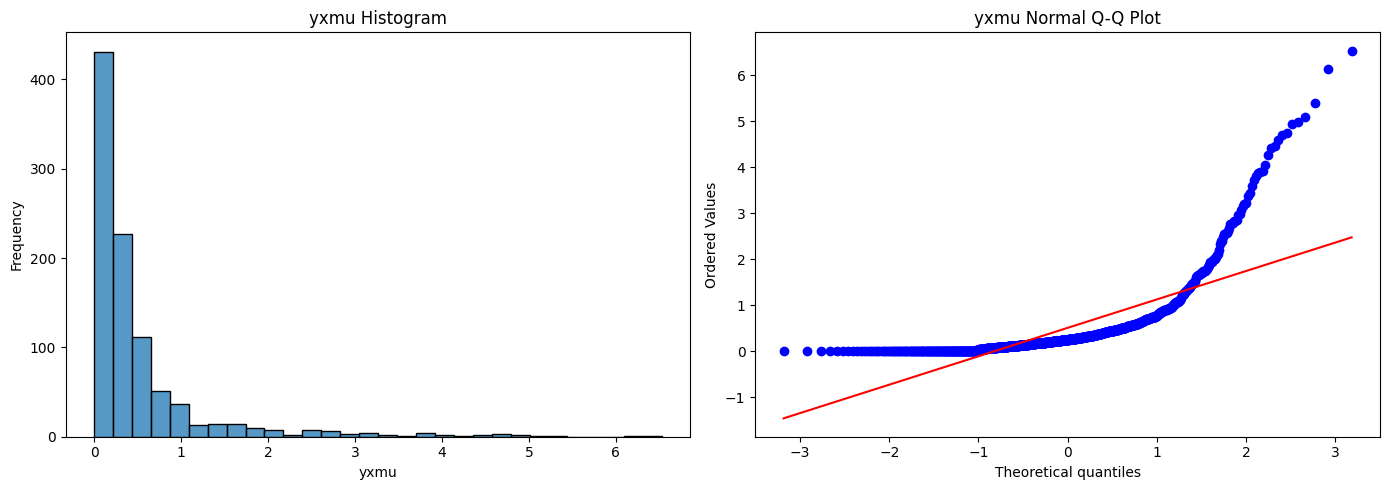

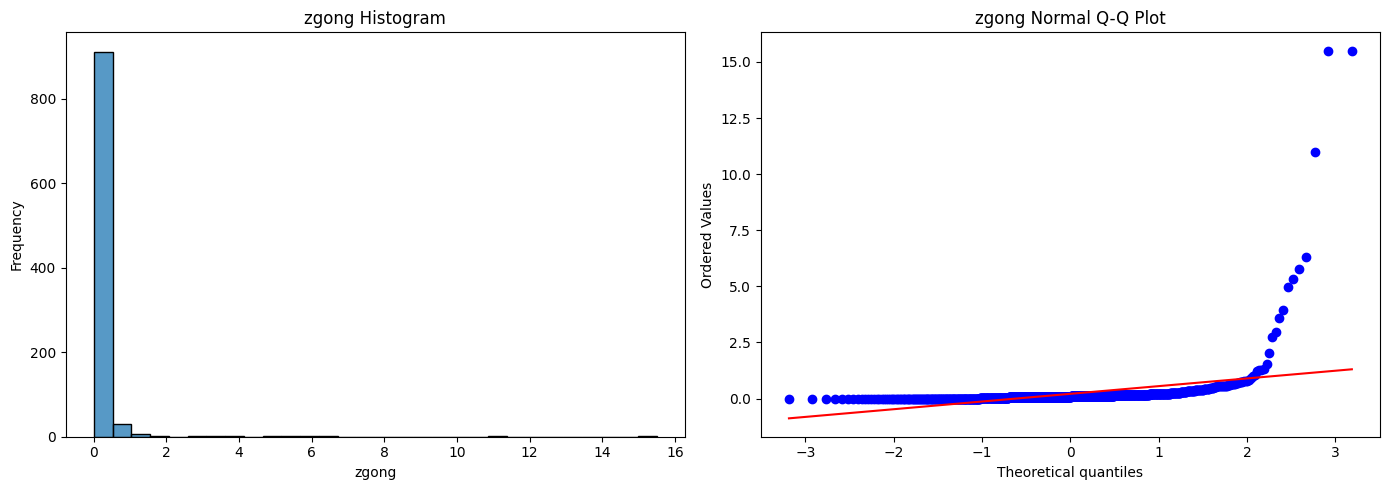

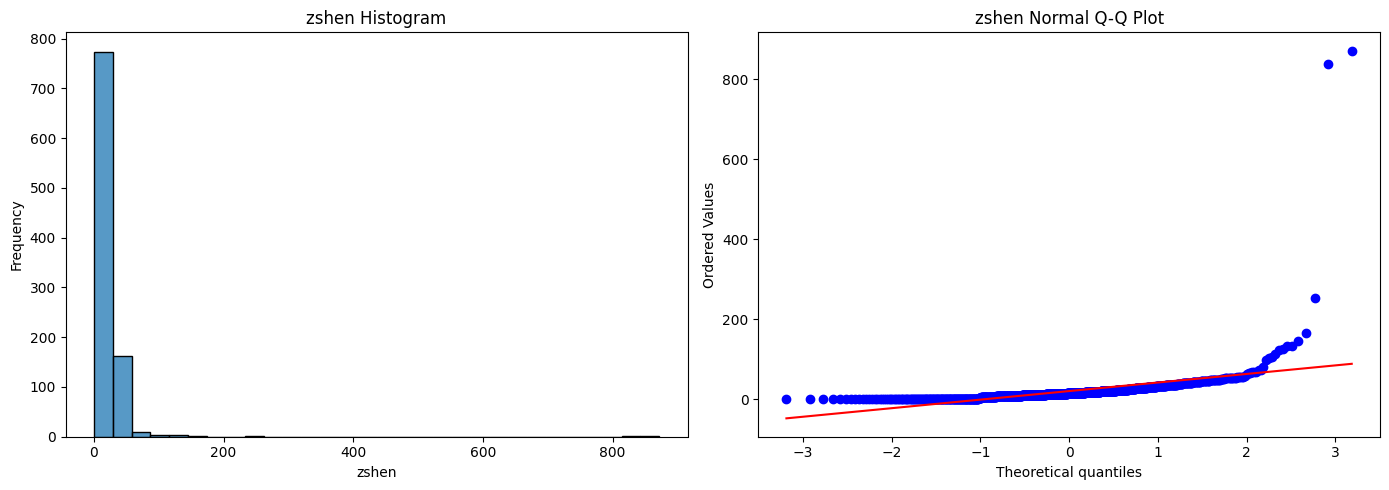

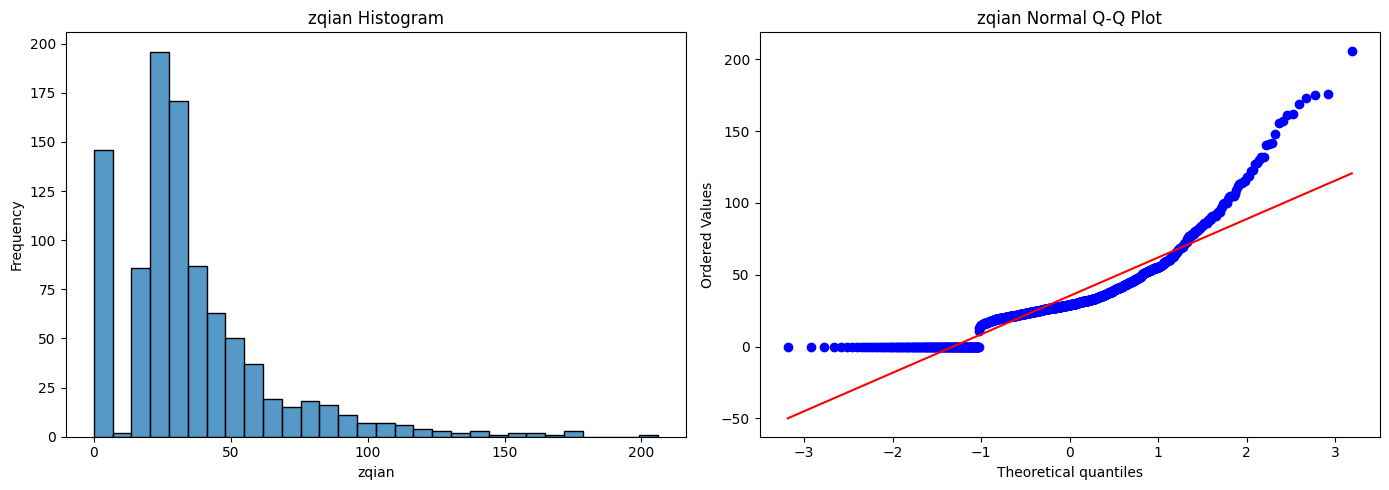

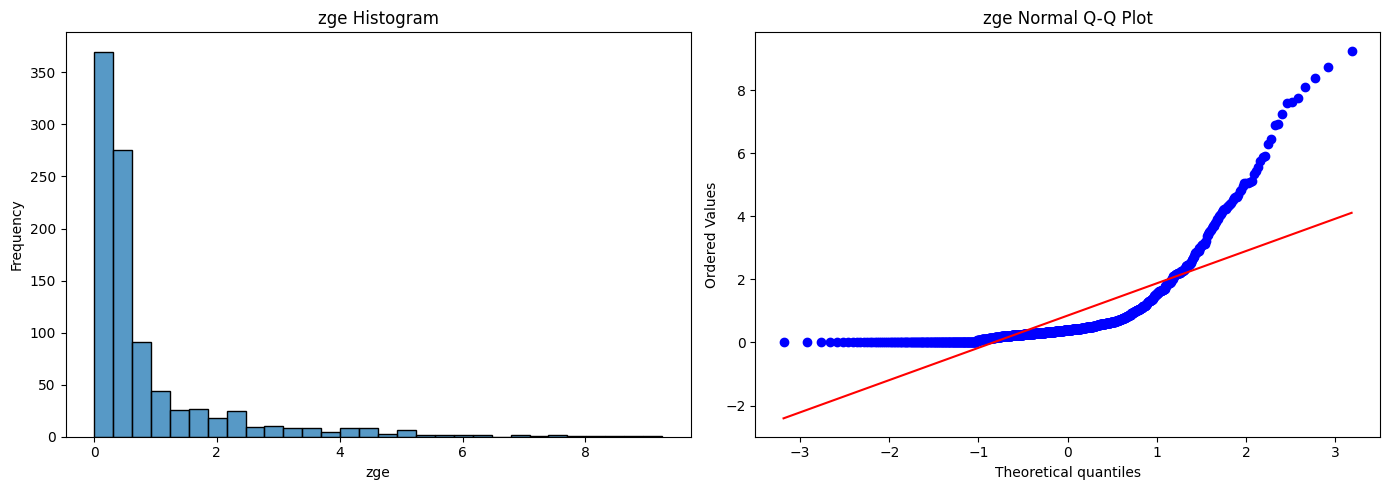

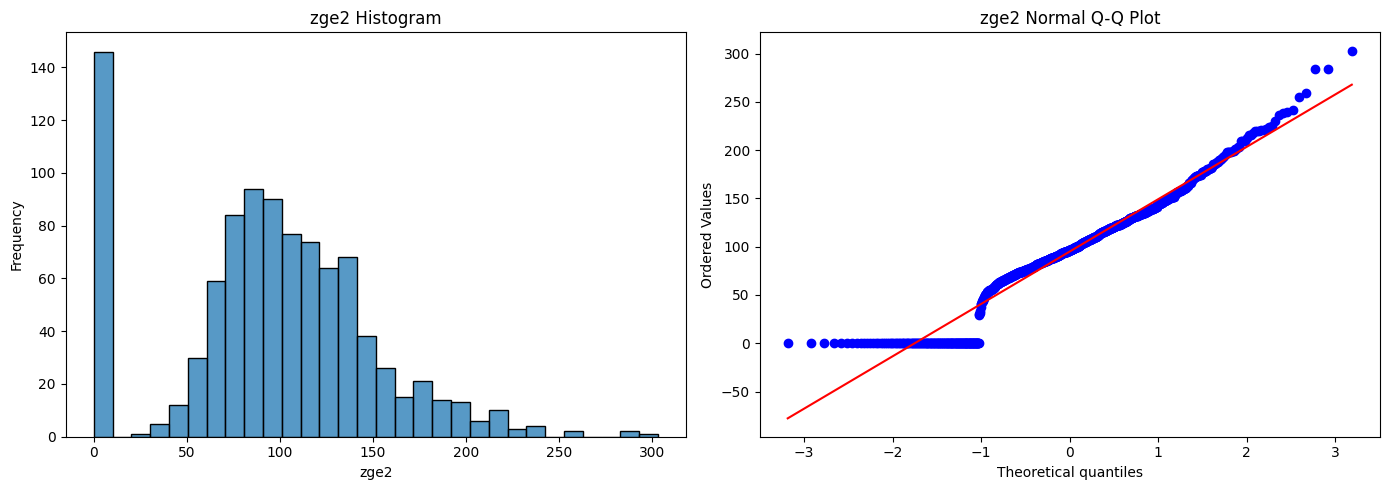

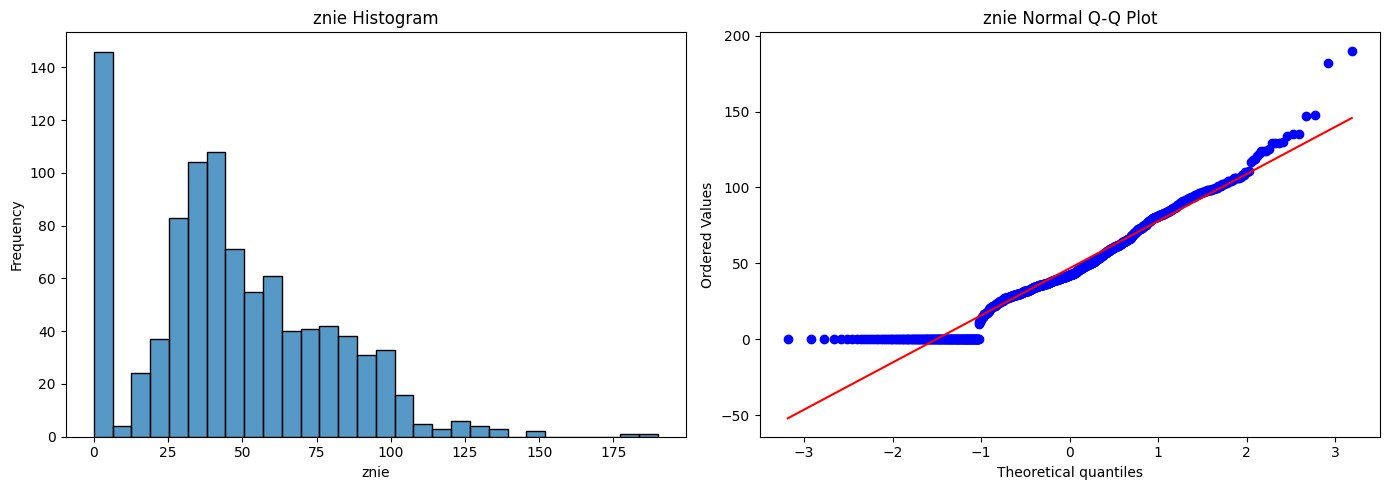

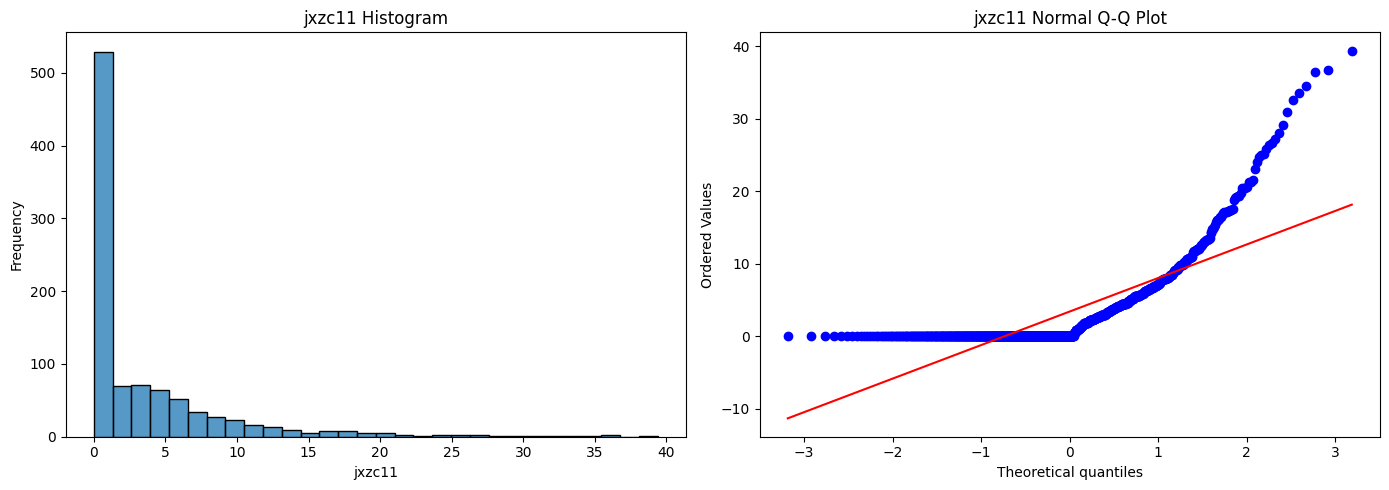

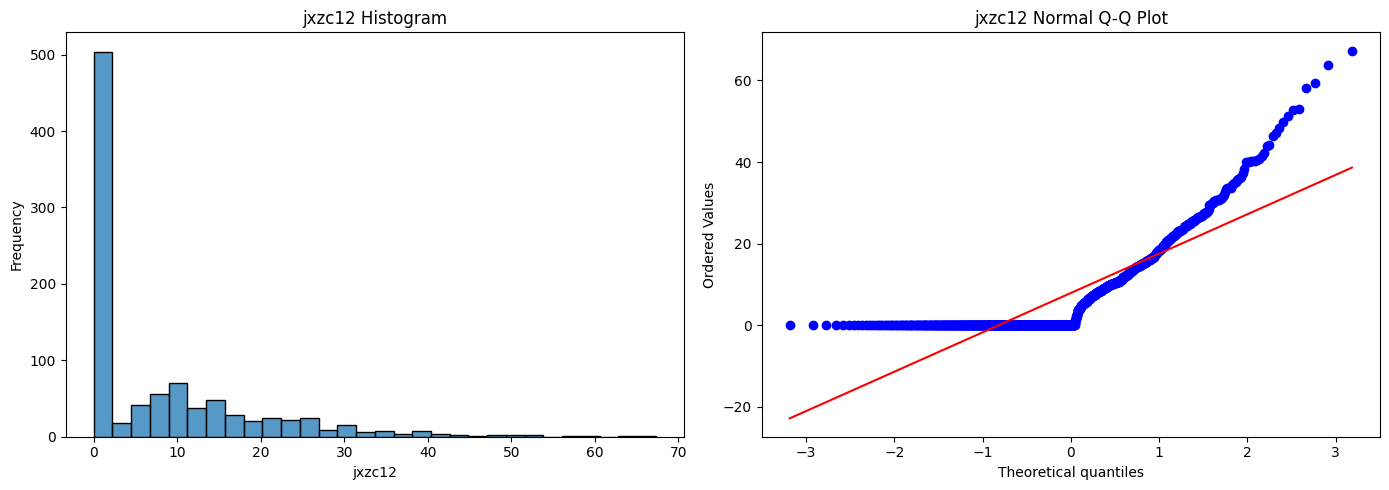

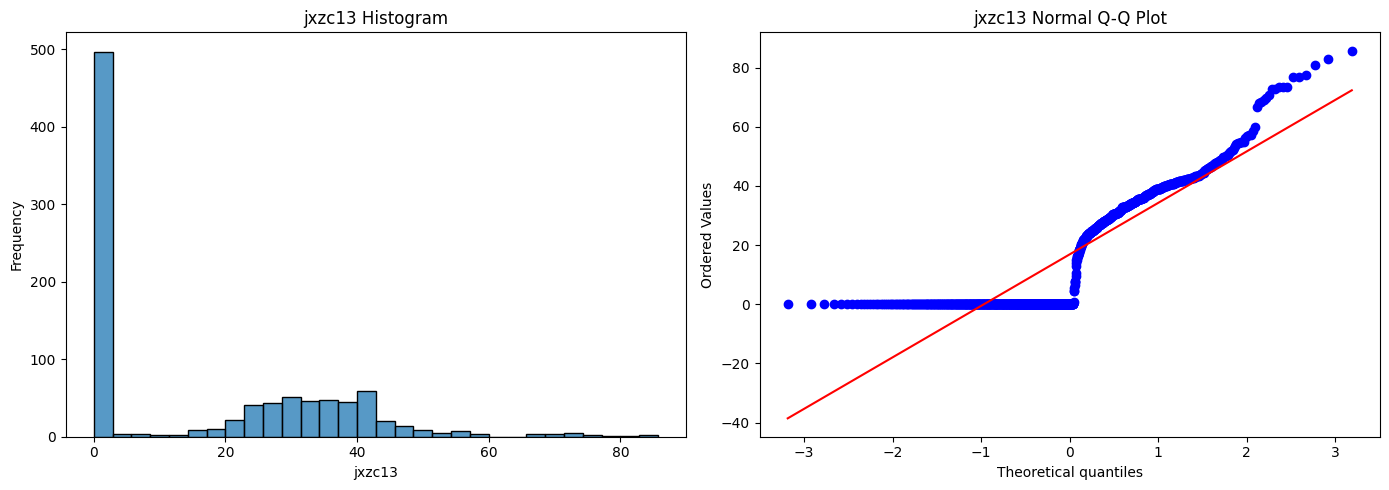

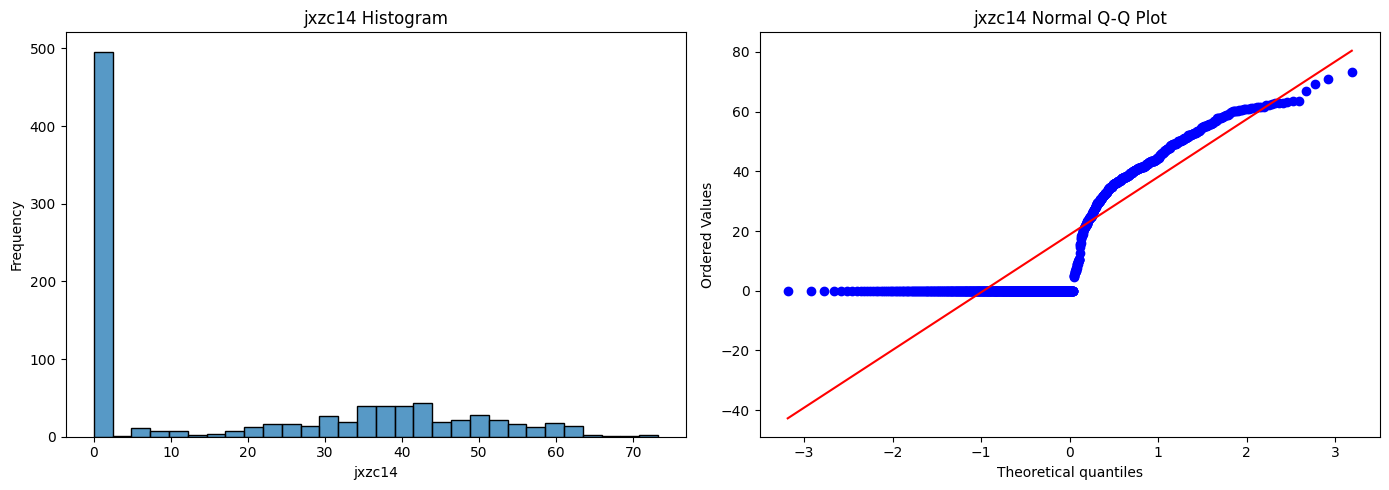

In [238]:
# 遍历df_result中的每一列
for column in result.columns[4:-1]:
    # 检查列的数据类型是否为数值型
    if pd.api.types.is_numeric_dtype(result[column]):
        # 创建一个图和两个子图
        fig, ax = plt.subplots(1, 2, figsize=(14, 5))

        # 在第一个子图上绘制直方图
        sns.histplot(result[column], kde=False, bins=30, ax=ax[0])
        ax[0].set_title(f'{column} Histogram')
        ax[0].set_xlabel(column)
        ax[0].set_ylabel('Frequency')

        # 在第二个子图上绘制正态分布检验图
        stats.probplot(result[column], plot=ax[1])
        ax[1].set_title(f'{column} Normal Q-Q Plot')

        # 调整布局并显示图
        plt.tight_layout()
        plt.show()
